In [2]:
library("dndscv")
library(dplyr)
library("biomaRt")
library(MASS) 
library(ggplot2)
library(lmtest)
library(stringr)
library(VennDiagram)
library(readr)
library(gridExtra)
library(RColorBrewer)
library(glue)
library(tidyr)

In [5]:
STAD_mutation_filtered_pass = read_tsv("/Users/shuhaoxu/Desktop/BNFO285/Groupproject/ECE204Repo/Project2/STAD_mutation_gmm_1.txt", quote="\"")


Rows: 32338 Columns: 53
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (44): patient_id, Hugo_Symbol, Center, NCBI_Build, Chromosome, Strand, V...
dbl  (9): Entrez_Gene_Id, Start_Position, End_Position, t_depth, t_ref_count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
transcript_ids <- unique(STAD_mutation_filtered_pass$Transcript_ID)

transcript_data <- getBM(attributes = c("ensembl_transcript_id", "hgnc_symbol", "transcript_length"),
                         filters = "ensembl_transcript_id",
                         values = transcript_ids,
                         mart = ensembl)

gene_lengths <- transcript_data %>%
  group_by(hgnc_symbol) %>%
  summarise(gene_length = max(transcript_length, na.rm = TRUE)) %>%
  ungroup()



Batch submitting query [=========>---------------------]  33% eta:  4s

Batch submitting query [====================>----------]  67% eta:  2s
                                                                      



# All pre-processing

In [9]:
mutation_counts <- STAD_mutation_filtered_pass %>% 
  group_by(Hugo_Symbol) %>% 
  summarise(observed_mutations = n()) %>% 
  ungroup()

mutation_counts_with_GeneLength <- mutation_counts %>%
  left_join(gene_lengths, by = c("Hugo_Symbol" = "hgnc_symbol"))

mutation_counts_filtered <- mutation_counts_with_GeneLength %>%
  filter(!is.na(gene_length))

mutation_counts_filtered$log_gene_length <- log(mutation_counts_filtered$gene_length + 1e-6)

total_mutations <- sum(mutation_counts_filtered$observed_mutations)
total_length <- sum(mutation_counts_filtered$gene_length)
avg_mutation_rate <- total_mutations / total_length
cat("Average mutation rate (mutations per bp):", avg_mutation_rate, "\n")

mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(expected_mutations = gene_length * avg_mutation_rate)

STAD_mutation_filtered_pass <- STAD_mutation_filtered_pass %>%
mutate(
  SIFT_numeric = as.numeric(str_extract(SIFT, "(?<=\\()\\d*\\.?\\d*(?=\\))")),
  SIFT = ifelse(SIFT == ".", NA, SIFT)
)

impact_scores <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(avg_sift = mean(SIFT_numeric, na.rm = TRUE)) %>%
  ungroup()

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(impact_scores, by = "Hugo_Symbol")

mutation_counts_filtered$avg_sift <- replace(mutation_counts_filtered$avg_sift, is.na(mutation_counts_filtered$avg_sift), 0)

mutation_types <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(
    dN = sum(Variant_Classification %in% c("Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins", "Splice_Site", "Translation_Start_Site")),
    dS = sum(Variant_Classification %in% c("Silent", "5'UTR", "Intron", "3'UTR", "3'Flank", "5'Flank"))
  ) %>%
  ungroup() %>%
  mutate(dN_dS = (dN / (dS + 1e-6)))

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(mutation_types[, c("Hugo_Symbol", "dN_dS")], by = "Hugo_Symbol")

mutation_types <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(
    dN = sum(Variant_Classification %in% c("Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins", "Splice_Site", "Translation_Start_Site")),
    dS = sum(Variant_Classification %in% c("Silent", "5'UTR", "Intron", "3'UTR", "3'Flank", "5'Flank"))
  ) %>%
  ungroup()

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(mutation_types, by = "Hugo_Symbol")

t <- (sum(mutation_counts_filtered$dS) + sum(mutation_counts_filtered$dN)) / total_length

syn_by_substitution <- STAD_mutation_filtered_pass %>%
  filter(Variant_Classification %in% c("Silent", "5'UTR", "Intron", "3'UTR", "3'Flank", "5'Flank")) %>%
  mutate(substitution = paste(Reference_Allele, Tumor_Seq_Allele2, sep = ">")) %>%
  group_by(Hugo_Symbol, substitution) %>%
  summarise(count = n(), .groups = "drop") %>%
  pivot_wider(names_from = substitution, values_from = count, values_fill = 0, 
              names_prefix = "syn_")

dS_per_gene <- STAD_mutation_filtered_pass %>%
  filter(Variant_Classification %in% c("Silent", "5'UTR", "Intron", "3'UTR", "3'Flank", "5'Flank")) %>%
  group_by(Hugo_Symbol) %>%
  summarise(dS = n(), .groups = "drop")

mutation_counts_filtered <- mutation_counts_filtered %>%
  {if ("dS" %in% colnames(.)) dplyr::select(., -dS) else .} %>%
  left_join(dS_per_gene, by = "Hugo_Symbol") %>%
  left_join(syn_by_substitution, by = "Hugo_Symbol") %>%
  mutate(
    dS = coalesce(dS, 0),
    across(starts_with("syn_"), ~ coalesce(.x, 0))
  )
   
substitution_counts <- STAD_mutation_filtered_pass %>%
  mutate(substitution = paste(Reference_Allele, Tumor_Seq_Allele2, sep = ">")) %>%
  group_by(substitution) %>%
  summarise(count = n(), .groups = "drop")

total_counts <- sum(substitution_counts$count)

substitution_rates <- substitution_counts %>%
  mutate(rate = count / total_counts)
   
syn_long <- mutation_counts_filtered %>%
  dplyr::select(Hugo_Symbol, dplyr::starts_with("syn_")) %>%
  pivot_longer(cols = dplyr::starts_with("syn_"), names_to = "substitution", 
               values_to = "L_i_s", names_prefix = "syn_") %>%
  filter(L_i_s > 0)

syn_long_with_rates <- syn_long %>%
  left_join(substitution_rates %>% dplyr::select(substitution, r_i = rate), 
            by = "substitution")

syn_long_with_rates <- syn_long_with_rates %>%
  mutate(contribution = r_i * L_i_s)
   
expected_syn_per_gene <- syn_long_with_rates %>%
  group_by(Hugo_Symbol) %>%
  summarise(sum_contribution = sum(contribution), .groups = "drop") %>%
  mutate(expected_syn = t * sum_contribution)

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(expected_syn_per_gene %>% dplyr::select(Hugo_Symbol, expected_syn), 
            by = "Hugo_Symbol")
   
mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(expected_syn = coalesce(expected_syn, 0))

Average mutation rate (mutations per bp): 0.0006689089 


# poisson

In [12]:
null_model <- glm(observed_mutations ~ 1 + offset(log_gene_length ), 
                  family = poisson(), 
                  data = mutation_counts_filtered)


combined_model <- glm(observed_mutations ~ avg_sift + dN_dS + offset(log_gene_length), 
                      family = poisson(), 
                      data = mutation_counts_filtered)

models <- list("Combined" = combined_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  print(AIC(null_model, models[[name]]))
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.30f, P-value: %.30f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}

dispersion_stat <- summary(combined_model)$deviance / summary(combined_model)$df.residual
cat("\nDispersion statistic for Combined Poisson Model:", dispersion_stat, "\n")
if (dispersion_stat > 1.5) {
  cat("Overdispersion.\n")
}

               df      AIC
null_model      1 47300.69
models[[name]]  3 46794.80

Likelihood Ratio Test: Combined vs. Null
LR Statistic: 509.883736008458072319626808166504, P-value: 0.000000000000000000000000000000

Dispersion statistic for Combined Poisson Model: 1.866203 
Overdispersion.


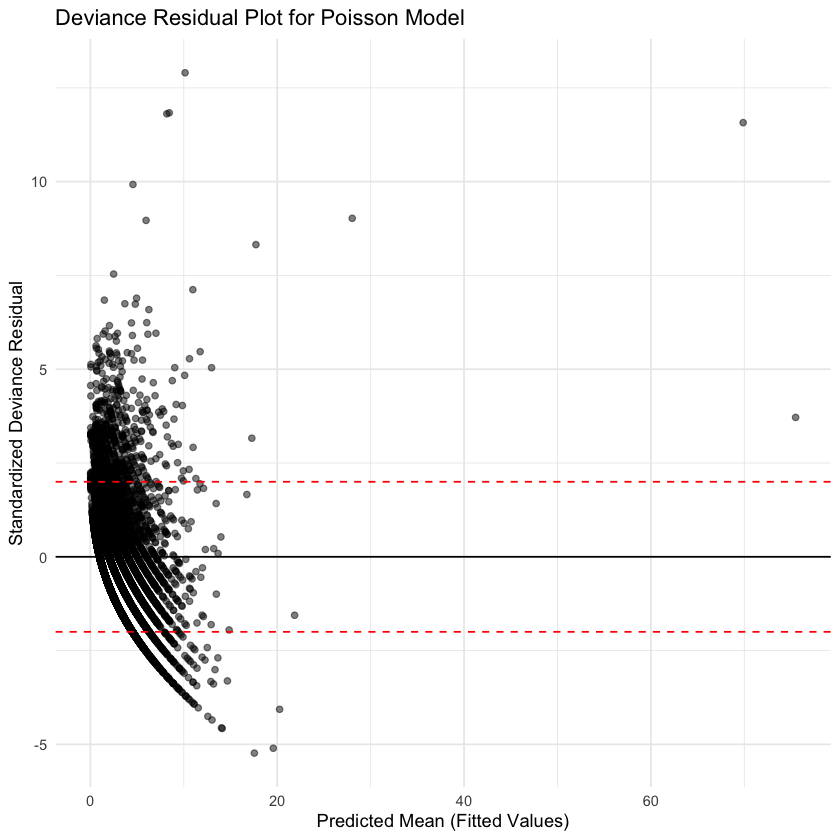

In [13]:
fitted_values <- fitted(combined_model)
std_deviance_residuals <- residuals(combined_model, type = "deviance") / sqrt(summary(combined_model)$dispersion)

plot_data <- data.frame(
  Predicted_Mean = fitted_values,
  Std_Dev_Residual = std_deviance_residuals
)

ggplot(plot_data, aes(x = Predicted_Mean, y = Std_Dev_Residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, color = "black", linetype = "solid") +
  geom_hline(yintercept = c(-2, 2), color = "red", linetype = "dashed") +
  labs(x = "Predicted Mean (Fitted Values)",
       y = "Standardized Deviance Residual",
       title = "Deviance Residual Plot for Poisson Model") +
  theme_minimal()

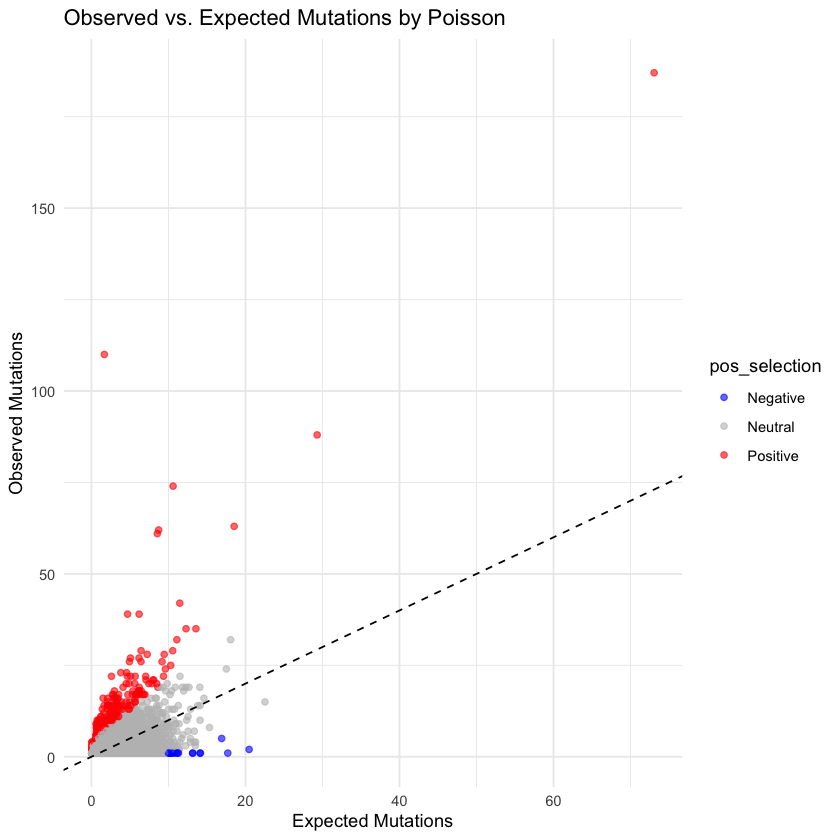

In [14]:
mutation_counts_filtered$pos_expected_mutations <- predict(combined_model, type = "response")

mutation_counts_filtered$pos_p_value <- mapply(function(obs, exp) {
  poisson.test(obs, r = exp, alternative = "two.sided")$p.value
}, mutation_counts_filtered$observed_mutations, mutation_counts_filtered$pos_expected_mutations)

mutation_counts_filtered$pos_adj_p_value <- p.adjust(mutation_counts_filtered$pos_p_value, method = "BH")
mutation_counts_filtered$pos_selection <- ifelse(mutation_counts_filtered$pos_adj_p_value < 0.05 & mutation_counts_filtered$observed_mutations > mutation_counts_filtered$expected_mutations, "Positive",
                                    ifelse(mutation_counts_filtered$pos_adj_p_value < 0.05 & mutation_counts_filtered$observed_mutations < mutation_counts_filtered$expected_mutations, "Negative", "Neutral"))

ggplot(mutation_counts_filtered, aes(x = expected_mutations, y = observed_mutations, color = pos_selection)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "gray")) +
  labs(x = "Expected Mutations", y = "Observed Mutations",
       title = "Observed vs. Expected Mutations by Poisson") +
  theme_minimal()

# NB

In [20]:
# Null Model
null_model <- glm.nb(observed_mutations ~ 1 + offset(log_gene_length), 
                     data = mutation_counts_filtered)

combined_model <- glm.nb(observed_mutations ~ avg_sift + offset(log_gene_length), 
                         data = mutation_counts_filtered)

# Likelihood Ratio Tests
models <- list("Combined" = combined_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  print(AIC(null_model, models[[name]]))
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.10f, P-value: %.40f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}


dispersion_stat <- summary(combined_model)$deviance / summary(combined_model)$df.residual
cat("\nDispersion statistic for Negative Binomial Model:", dispersion_stat, "\n")
if (dispersion_stat > 1.5) {
  cat("Overdispersion.\n")
}

               df      AIC
null_model      2 42896.00
models[[name]]  3 42870.85

Likelihood Ratio Test: Combined vs. Null
LR Statistic: 27.1468787728, P-value: 0.0000001885693961689430835605642451657804

Dispersion statistic for Negative Binomial Model: 0.9363755 


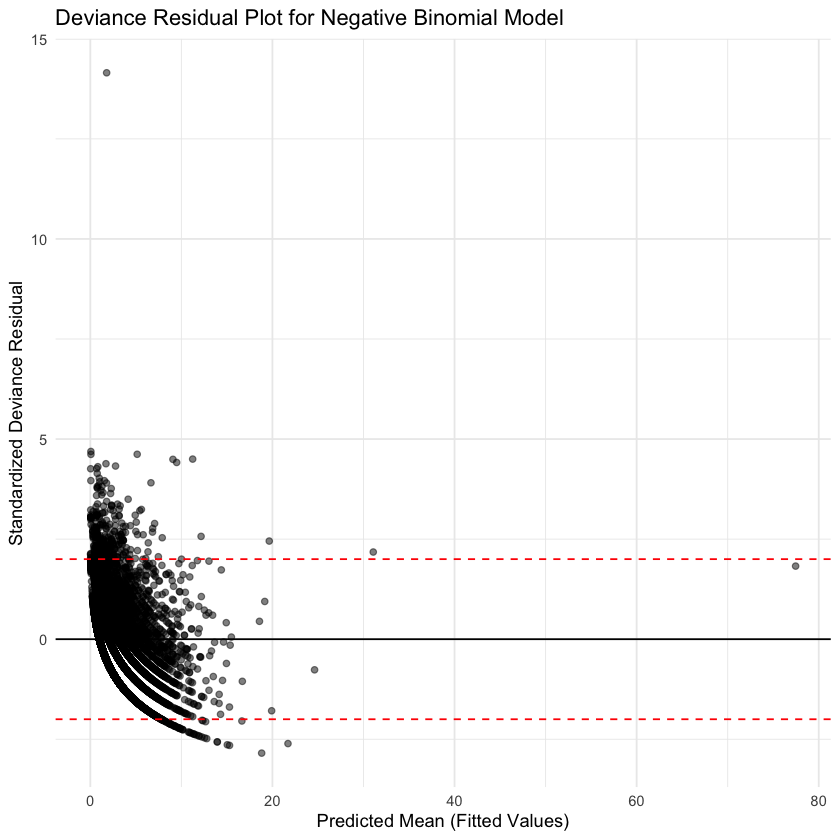

In [21]:
fitted_values <- fitted(combined_model)
std_deviance_residuals <- residuals(combined_model, type = "deviance") / sqrt(summary(combined_model)$dispersion)

plot_data <- data.frame(
  Predicted_Mean = fitted_values,
  Std_Dev_Residual = std_deviance_residuals
)

ggplot(plot_data, aes(x = Predicted_Mean, y = Std_Dev_Residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, color = "black", linetype = "solid") +
  geom_hline(yintercept = c(-2, 2), color = "red", linetype = "dashed") +
  labs(x = "Predicted Mean (Fitted Values)",
       y = "Standardized Deviance Residual",
       title = "Deviance Residual Plot for Negative Binomial Model") +
  theme_minimal()

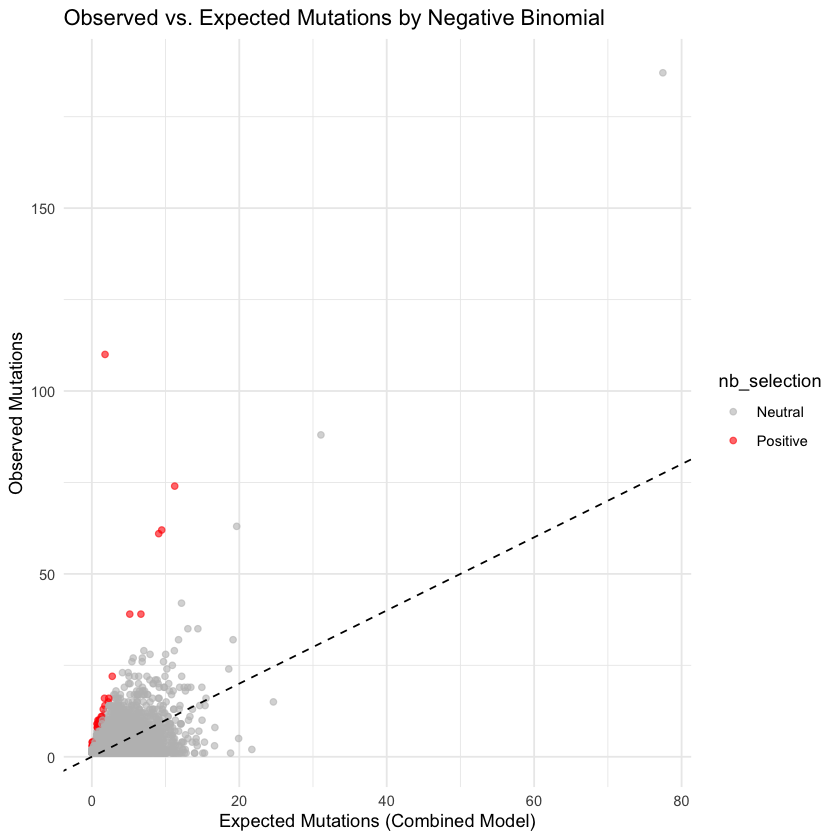

In [22]:
mutation_counts_filtered$nb_expected_mutations <- predict(combined_model, type = "response")

mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    diff_obs_exp = observed_mutations - nb_expected_mutations,
    ratio_obs_exp = observed_mutations / nb_expected_mutations
  )

# Use a Negative Binomial test: compare observed to expected under the NB distribution
mutation_counts_filtered$nb_p_value <- sapply(1:nrow(mutation_counts_filtered), function(i) {
  obs <- mutation_counts_filtered$observed_mutations[i]
  exp <- mutation_counts_filtered$nb_expected_mutations[i]
  theta <- combined_model$theta
  if (obs > exp) {
    p <- 1 - pnbinom(obs - 1, mu = exp, size = theta)
  } else {
    p <- pnbinom(obs, mu = exp, size = theta)
  }
  return(p)
})


mutation_counts_filtered$nb_adj_p_value <- p.adjust(mutation_counts_filtered$nb_p_value, method = "BH")
mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    nb_selection = case_when(
      nb_adj_p_value < 0.05 & ratio_obs_exp > 1 ~ "Positive",
      nb_adj_p_value < 0.05 & ratio_obs_exp < 1 ~ "Negative",
      TRUE ~ "Neutral"
    )
  )

ggplot(mutation_counts_filtered, aes(x = nb_expected_mutations, y = observed_mutations, color = nb_selection)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "gray")) +
  labs(x = "Expected Mutations (Combined Model)", y = "Observed Mutations",
       title = "Observed vs. Expected Mutations by Negative Binomial") +
  theme_minimal()

# NB dnds

In [44]:
dNdScv_model <- glm.nb(dS ~ avg_sift + offset(log(expected_syn + 1e-6)), 
                   data = mutation_counts_filtered,
                      control = glm.control(maxit = 30))

mutation_counts_filtered$expected_syn_predicted <- fitted(dNdScv_model)

models <- list("dNdS Model" = dNdScv_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  print(AIC(null_model, models[[name]]))
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.30f, P-value: %.30f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


               df      AIC
null_model      2 42896.00
models[[name]]  3 15988.83

Likelihood Ratio Test: dNdS Model vs. Null
LR Statistic: 26909.172119118920818436890840530396, P-value: 0.000000000000000000000000000000


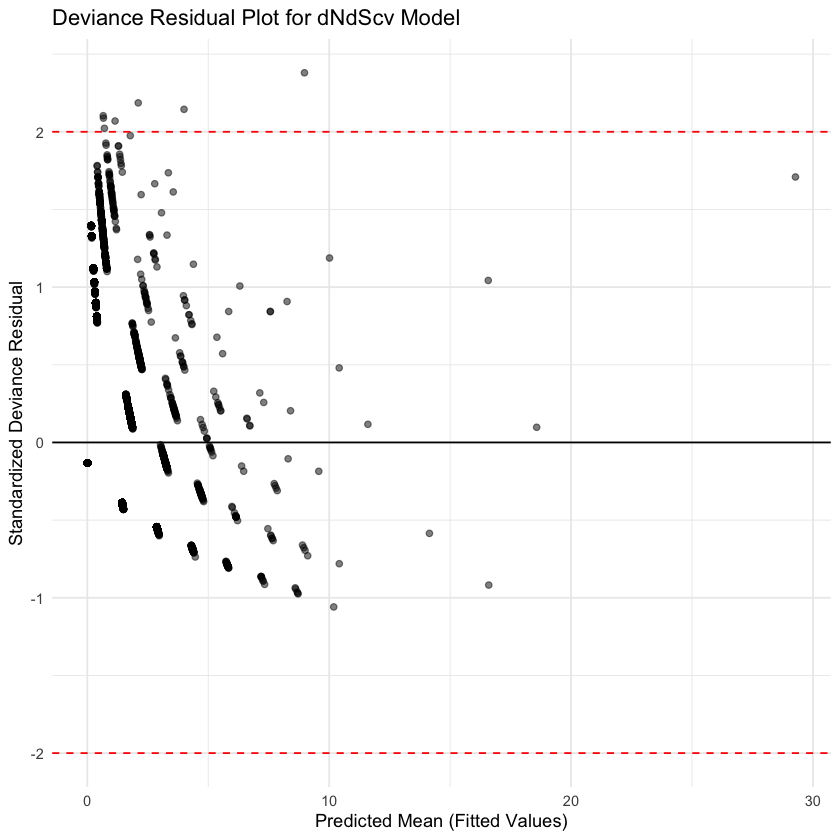

In [45]:
fitted_values <- fitted(dNdScv_model)
std_deviance_residuals <- residuals(dNdScv_model, type = "deviance") / sqrt(summary(dNdScv_model)$dispersion)

plot_data <- data.frame(
  Predicted_Mean = fitted_values,
  Std_Dev_Residual = std_deviance_residuals
)

ggplot(plot_data, aes(x = Predicted_Mean, y = Std_Dev_Residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, color = "black", linetype = "solid") +
  geom_hline(yintercept = c(-2, 2), color = "red", linetype = "dashed") +
  labs(x = "Predicted Mean (Fitted Values)",
       y = "Standardized Deviance Residual",
       title = "Deviance Residual Plot for dNdScv Model") +
  theme_minimal()

In [46]:
mutation_counts_filtered$expected_dN_predicted <- mutation_counts_filtered$expected_syn_predicted * mutation_counts_filtered$dN_dS

In [47]:
mutation_counts_filtered$dnds_p_value <- sapply(1:nrow(mutation_counts_filtered), function(i) {
  obs <- mutation_counts_filtered$dN[i]
  exp <- mutation_counts_filtered$expected_dN_predicted[i]
  theta <- dNdScv_model$theta
  if (obs > exp) {
    p <- 1 - pnbinom(obs - 1, mu = exp, size = theta)
  } else {
    p <- pnbinom(obs, mu = exp, size = theta)
  }
  return(p)
})

mutation_counts_filtered$dnds_adj_p_value <- p.adjust(mutation_counts_filtered$dnds_p_value, method = "BH")

In [ ]:
# mutation_counts_filtered$predicted_dNdS = mutation_counts_filtered$expected_dN_predicted / mutation_counts_filtered$expected_syn_predicted

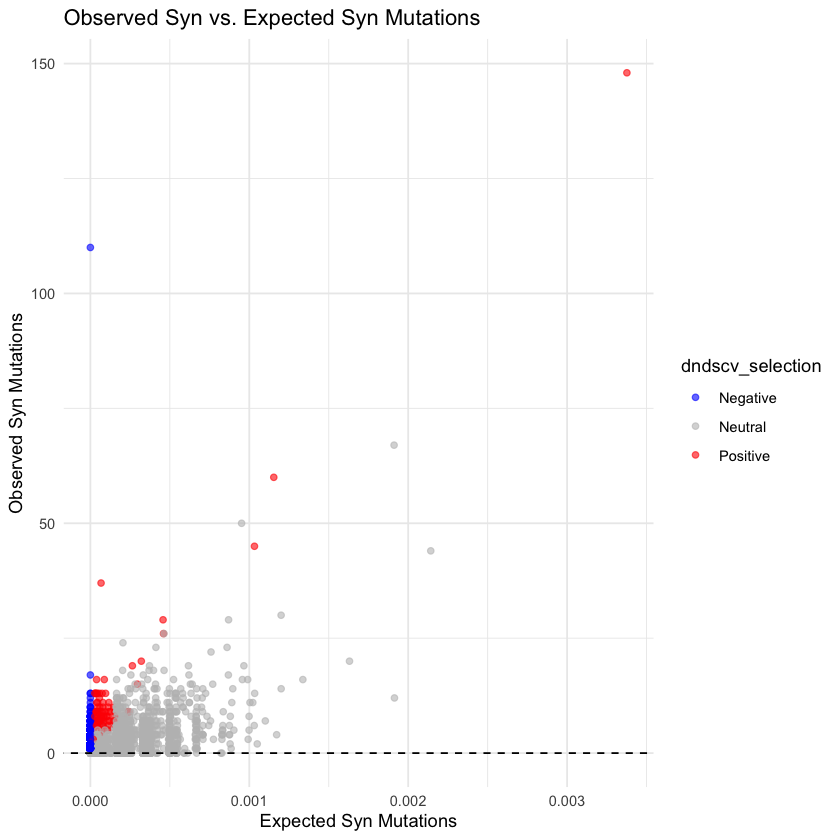

In [48]:
mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    dndscv_selection = case_when(
      dnds_adj_p_value < 0.05 & expected_dN_predicted < dN ~ "Positive",
      dnds_adj_p_value < 0.05 & expected_dN_predicted > dN ~ "Negative",
      TRUE ~ "Neutral"
    )
  )

ggplot(mutation_counts_filtered, aes(x = expected_syn, y = dN, color = dndscv_selection)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "gray")) +
  labs(x = "Expected Syn Mutations", y = "Observed Syn Mutations",
       title = "Observed Syn vs. Expected Syn Mutations") +
  theme_minimal()

# Gamma

In [64]:
null_model <- glm(observed_mutations ~ 1 + offset(log_gene_length) + offset(expected_syn), 
                  family = Gamma(link = "log"), 
                  data = mutation_counts_filtered)

combined_model <- glm(observed_mutations ~ avg_sift + dN_dS + offset(expected_syn) + offset(log_gene_length), 
                      family = Gamma(link = "log"), 
                      data = mutation_counts_filtered,
                     control = glm.control(maxit = 40))

models <- list(
    "Combined" = combined_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  print(AIC(null_model, models[[name]]))
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.30f, P-value: %.30f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}

dispersion_stat <- summary(combined_model)$deviance / summary(combined_model)$df.residual
cat("\nDispersion statistic for Combined Gamma Model:", dispersion_stat, "\n")
if (dispersion_stat > 1.5) {
  cat("Overdispersion.\n")
}

Warning message:
“glm.fit: algorithm did not converge”


               df      AIC
null_model      2 43723.35
models[[name]]  4 43700.15

Likelihood Ratio Test: Combined vs. Null
LR Statistic: 27.202668051562795881181955337524, P-value: 0.000001238841330855576228887156

Dispersion statistic for Combined Gamma Model: 0.8646218 


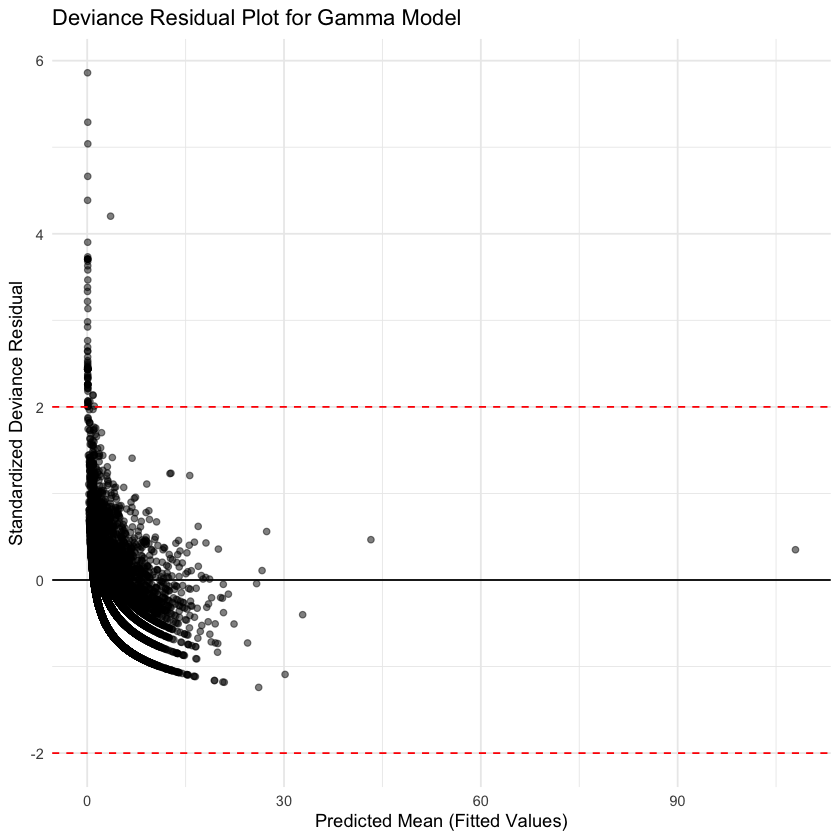

In [65]:
fitted_values <- fitted(combined_model)
std_deviance_residuals <- residuals(combined_model, type = "deviance") / sqrt(summary(combined_model)$dispersion)

plot_data <- data.frame(
  Predicted_Mean = fitted_values,
  Std_Dev_Residual = std_deviance_residuals
)

ggplot(plot_data, aes(x = Predicted_Mean, y = Std_Dev_Residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, color = "black", linetype = "solid") +
  geom_hline(yintercept = c(-2, 2), color = "red", linetype = "dashed") +
  labs(x = "Predicted Mean (Fitted Values)",
       y = "Standardized Deviance Residual",
       title = "Deviance Residual Plot for Gamma Model") +
  theme_minimal()

In [66]:
mutation_counts_filtered$gm_expected_mutations <- predict(combined_model, type = "response")
phi <- summary(combined_model)$dispersion
mutation_counts_filtered$gm_p_value <- mapply(function(obs, exp) {
  shape <- 1 / phi
  scale <- exp * phi
  if (obs > exp) {
    p <- 1 - pgamma(obs, shape = shape, scale = scale)
  } else {
    p <- pgamma(obs, shape = shape, scale = scale)
  }
  return(p)
}, mutation_counts_filtered$observed_mutations, mutation_counts_filtered$gm_expected_mutations)

mutation_counts_filtered$gm_adj_p_value <- p.adjust(mutation_counts_filtered$gm_p_value, method = "BH")

mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    ratio_obs_exp = observed_mutations / gm_expected_mutations,
    gm_selection = case_when(
      gm_adj_p_value < 0.05 & ratio_obs_exp > 1 ~ "Positive",
      gm_adj_p_value < 0.05 & ratio_obs_exp < 1 ~ "Negative",
      TRUE ~ "Neutral"
    )
  )

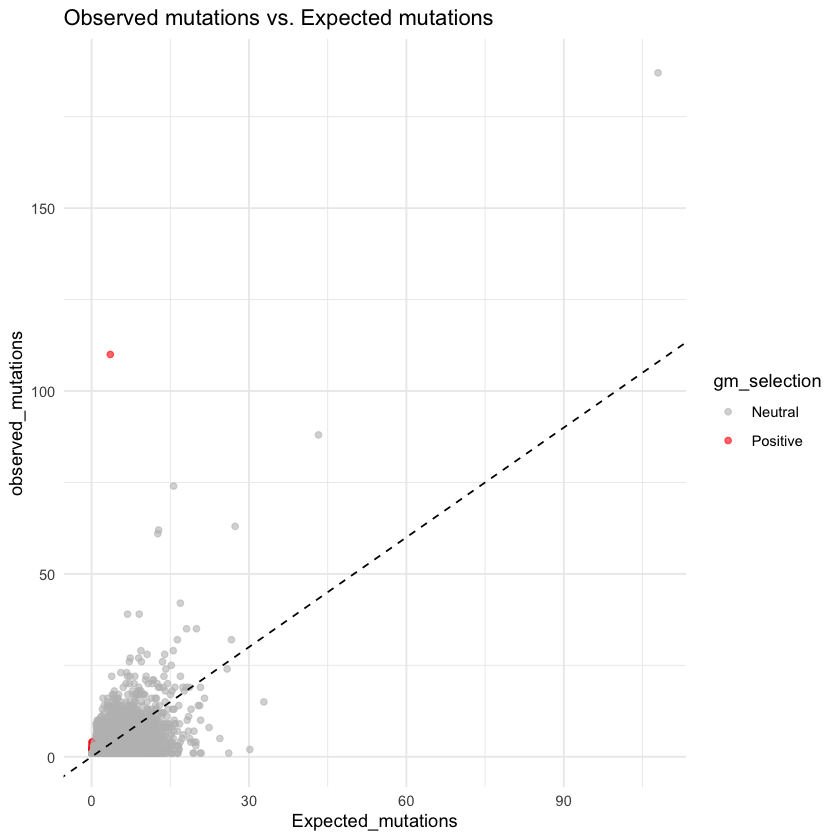

In [67]:
ggplot(mutation_counts_filtered, aes(x = gm_expected_mutations, y = observed_mutations, color = gm_selection)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "gray")) +
  labs(x = "Expected_mutations", y = "observed_mutations",
       title = "Observed mutations vs. Expected mutations") +
  theme_minimal()

In [68]:
table(mutation_counts_filtered$gm_selection)


 Neutral Positive 
   10424       17 

# Binomial

In [69]:
expected_dN_dS <- mean(mutation_counts_filtered$dN) / mean(mutation_counts_filtered$dS)
mutation_counts_filtered$total_mutations <- mutation_counts_filtered$dN + mutation_counts_filtered$dS

mutation_counts_filtered$dN_frac <- mutation_counts_filtered$dN / (mutation_counts_filtered$dN + mutation_counts_filtered$dS)
expected_dN_frac <- mean(mutation_counts_filtered$dN) / (mean(mutation_counts_filtered$dN) + mean(mutation_counts_filtered$dS))
mutation_counts_filtered$expected_dN <- as.integer(mutation_counts_filtered$total_mutations * expected_dN_frac)

mutation_counts_filtered$dnds_p_value <- mapply(function(dN, total, exp_dN) {
  if (total == 0) return(1)
  binom.test(dN, total, p = exp_dN/total, alternative = "two.sided")$p.value
}, mutation_counts_filtered$dN, mutation_counts_filtered$total_mutations, mutation_counts_filtered$expected_dN)

mutation_counts_filtered$dnds_adj_p_value <- p.adjust(mutation_counts_filtered$dnds_p_value, method = "BH")
mutation_counts_filtered$dnds_selection <- ifelse(mutation_counts_filtered$dnds_adj_p_value < 0.05 & 
                                                  mutation_counts_filtered$dN > mutation_counts_filtered$expected_dN, "Positive",
                                                  ifelse(mutation_counts_filtered$dnds_adj_p_value < 0.05 & 
                                                         mutation_counts_filtered$dN < mutation_counts_filtered$expected_dN, "Negative", "Neutral"))

# Output

In [138]:
write_delim(mutation_counts_filtered, "mutation_counts_filtered_clust1.tsv", delim = " ")

# Load other files

In [71]:
STAD_mutation_sub <- STAD_mutation_filtered_pass[, c("patient_id", "Chromosome", "Start_Position", "Reference_Allele", "Tumor_Seq_Allele2")]
colnames(STAD_mutation_sub) <- c("sampleID", "chr", "pos", "ref", "mut")
STAD_dndsout <- dndscv(STAD_mutation_sub)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(STAD_mutation_sub):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”
Warning message in dndscv(STAD_mutation_sub):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”
    Note: 36 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

    35% ...

    70% ...

[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Regression model for substitutions (theta = 3.46).



In [81]:
STAD_sel_cv = STAD_dndsout$sel_cv
STAD_signif_genes = STAD_sel_cv[STAD_sel_cv$qallsubs_cv<0.05, c("gene_name","qallsubs_cv")]
FML = read_delim("20250429cbase/q_values_20250429cbase.txt", delim="\t", skip = 1)
CLUSTL = read_delim("20250429_oncoCLUST/clusters_results.tsv", delim="\t", show_col_types = FALSE)
CLUSTL$adj_p_value <- p.adjust(CLUSTL$P, method = "BH")
IntOGen = read_tsv("IntOGen-DriverGenes_STAD.tsv", quote="\"")

Rows: 18439 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): gene
dbl (29): p_phi_m_neg, q_phi_m_neg, phi_m_neg, p_phi_k_neg, q_phi_k_neg, phi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 74 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Symbol
dbl (4): Mutations, Samples, Samples (%), Cohorts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [109]:
dnds_naive = read_tsv("dnds_naive.tsv", quote="\"")

Rows: 13156 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Hugo_Symbol
dbl (3): dN, dS, dN/dS

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [119]:
naive_sig_genes <- dnds_naive[0:20,] %>%
  pull(Hugo_Symbol) %>%
  unique()

# plot venndiagram

In [101]:
pos_sig_genes <- mutation_counts_filtered %>%
  filter(pos_selection == "Positive" & pos_adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

nb_sig_genes <- mutation_counts_filtered %>%
  filter(nb_selection == "Positive" & nb_adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

dnds_sig_genes <- mutation_counts_filtered %>%
  filter(dnds_selection == "Positive" & dnds_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

gm_sig_genes <- mutation_counts_filtered %>%
  filter(gm_selection == "Positive" & gm_adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

dndscv_significant_genes <- STAD_sel_cv %>%
  filter(qallsubs_cv < 0.05) %>%
  pull(gene_name) %>%
  unique()

FML_sig_genes <- FML %>%
  filter(q_phi_pos < 0.05) %>%
  pull(gene) %>%
  unique()

CLUSTL_sig <- CLUSTL %>%
  filter(adj_p_value < 0.05) %>%
  pull(SYMBOL) %>%
  unique()

IntOGen_genes <- IntOGen %>%
  pull(Symbol) %>%
  unique()

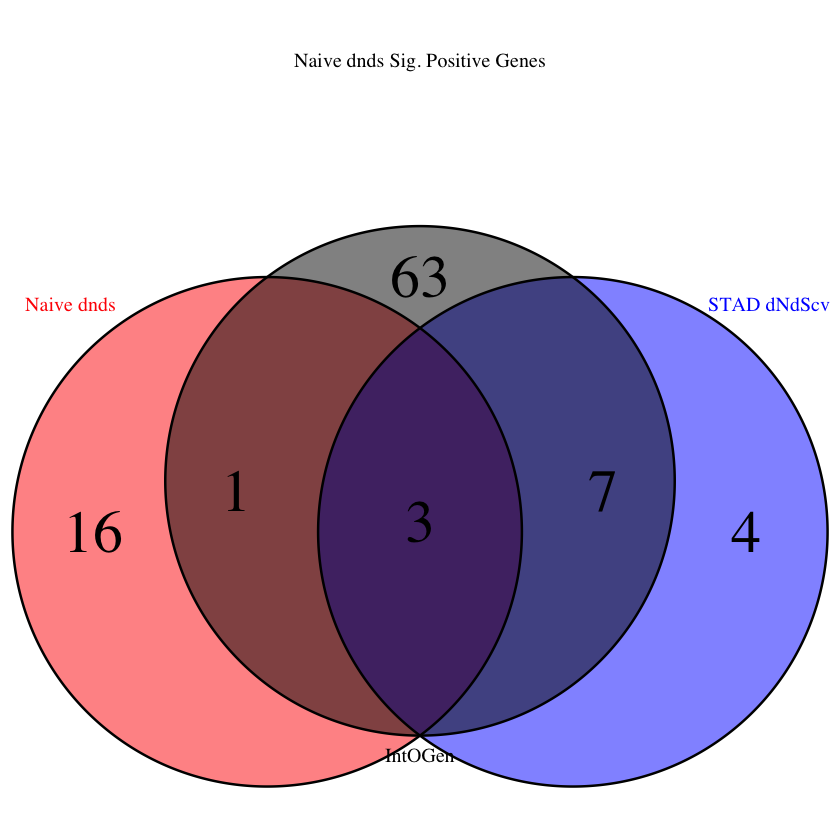

In [132]:
fill_colors <- c("red", "blue", "black")

venn_plot <- venn.diagram(
  x = list(
      "Naive dnds" = naive_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes,
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Naive dnds Sig. Positive Genes",
  alpha = 0.5,
  label.col = "black",
  cex = 3,
  cat.cex = 1,
  cat.col = fill_colors,
  margin = 0
)
grid.draw(venn_plot)

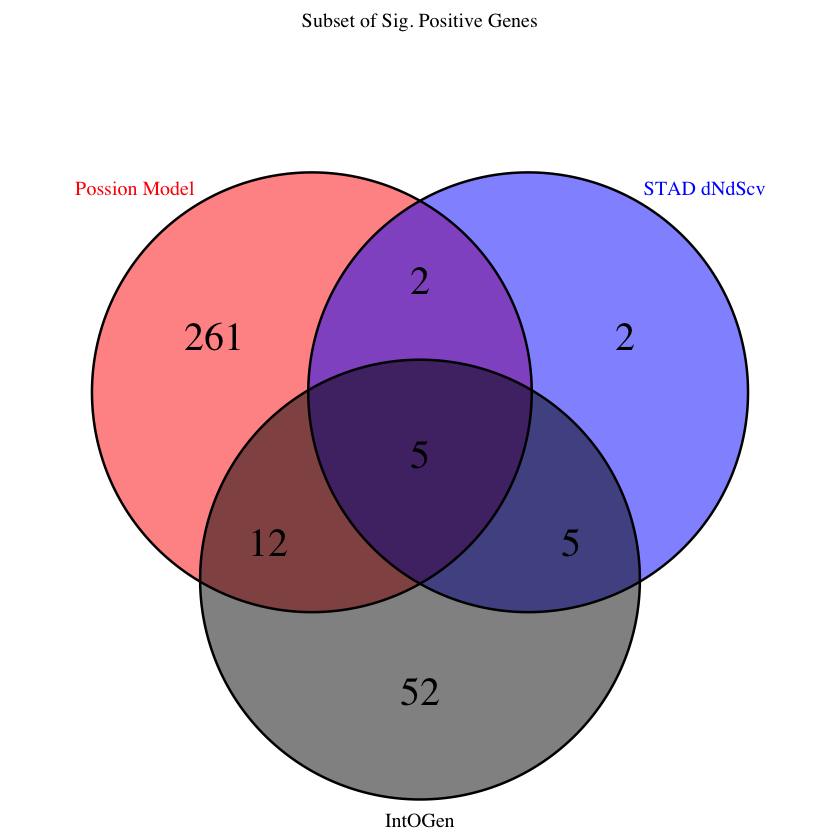

In [108]:
fill_colors <- c("red", "blue", "black")

venn_plot <- venn.diagram(
  x = list(
      "Possion Model" = pos_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes,
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Subset of Sig. Positive Genes",
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1,
  cat.col = fill_colors,
  margin = 0.1
)
grid.draw(venn_plot)

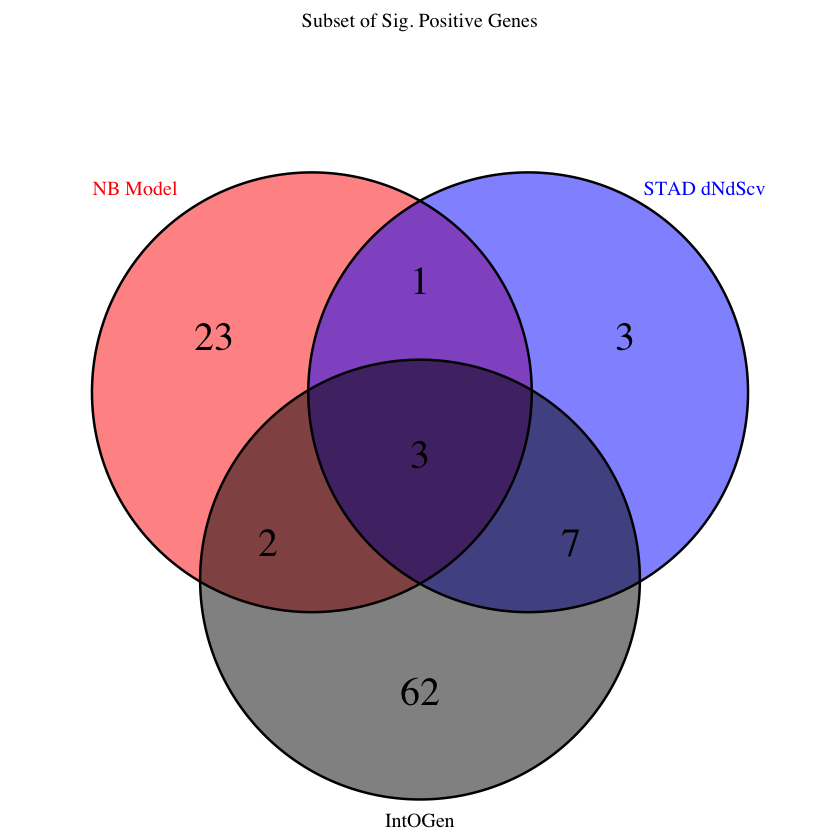

In [107]:
fill_colors <- c("red", "blue", "black")

venn_plot <- venn.diagram(
  x = list(
      "NB Model" = nb_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes,
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Subset of Sig. Positive Genes",
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1,
  cat.col = fill_colors,
  margin = 0.1
)
grid.draw(venn_plot)

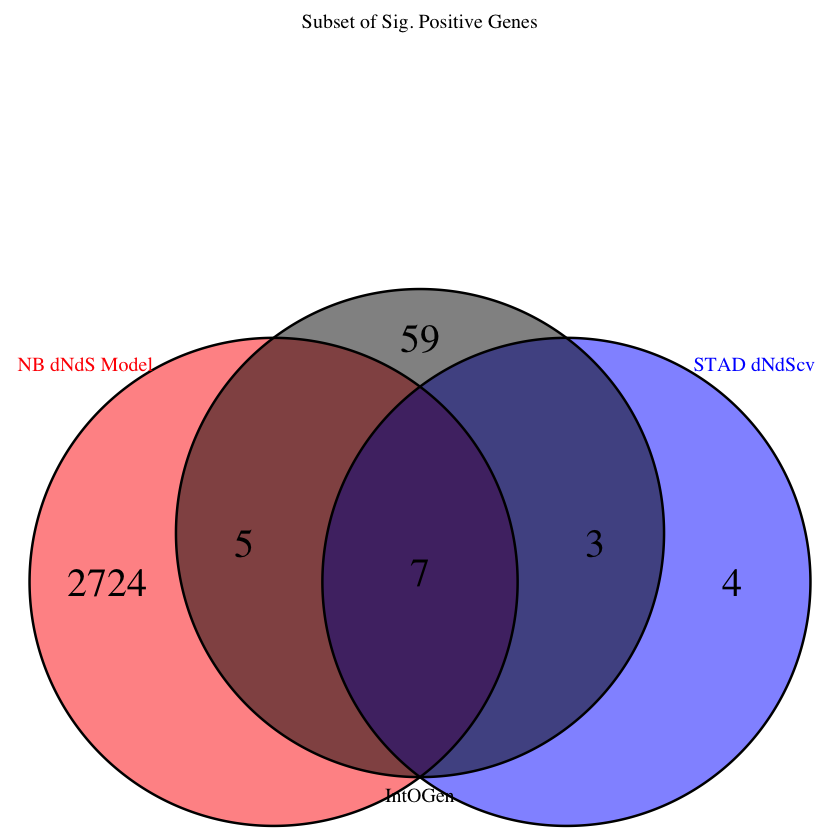

In [106]:
fill_colors <- c("red", "blue", "black")

venn_plot <- venn.diagram(
  x = list(
      "NB dNdS Model" = dnds_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes,
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Subset of Sig. Positive Genes",
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1,
  cat.col = fill_colors,
  margin = 0.1
)
grid.draw(venn_plot)

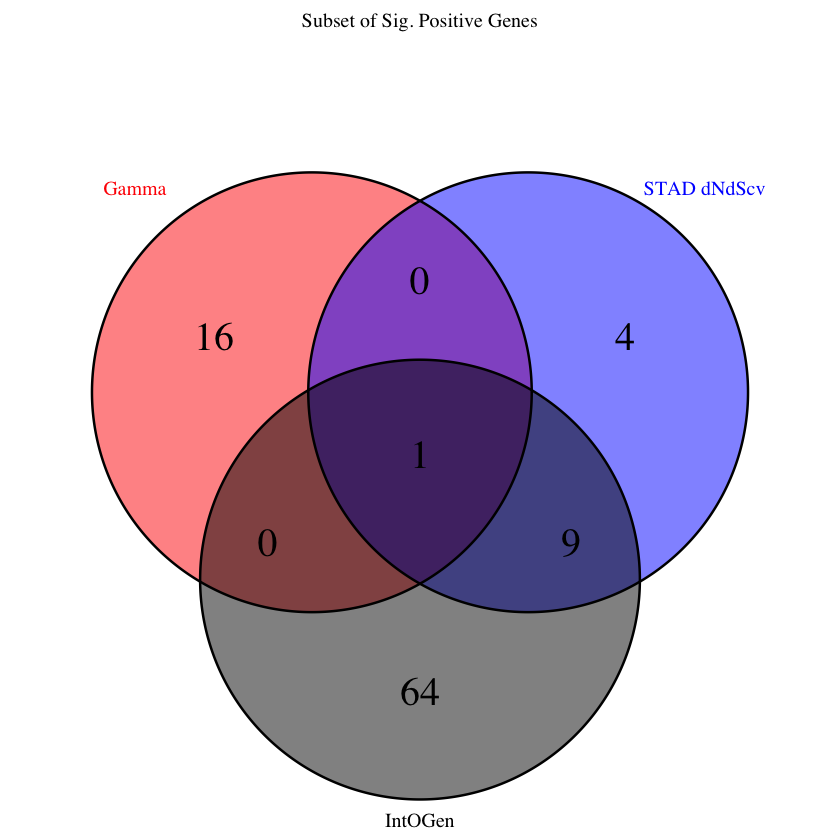

In [105]:
fill_colors <- c("red", "blue", "black")

venn_plot <- venn.diagram(
  x = list(
      "Gamma" = gm_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes,
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Subset of Sig. Positive Genes",
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1,
  cat.col = fill_colors,
  margin = 0.1
)
grid.draw(venn_plot)

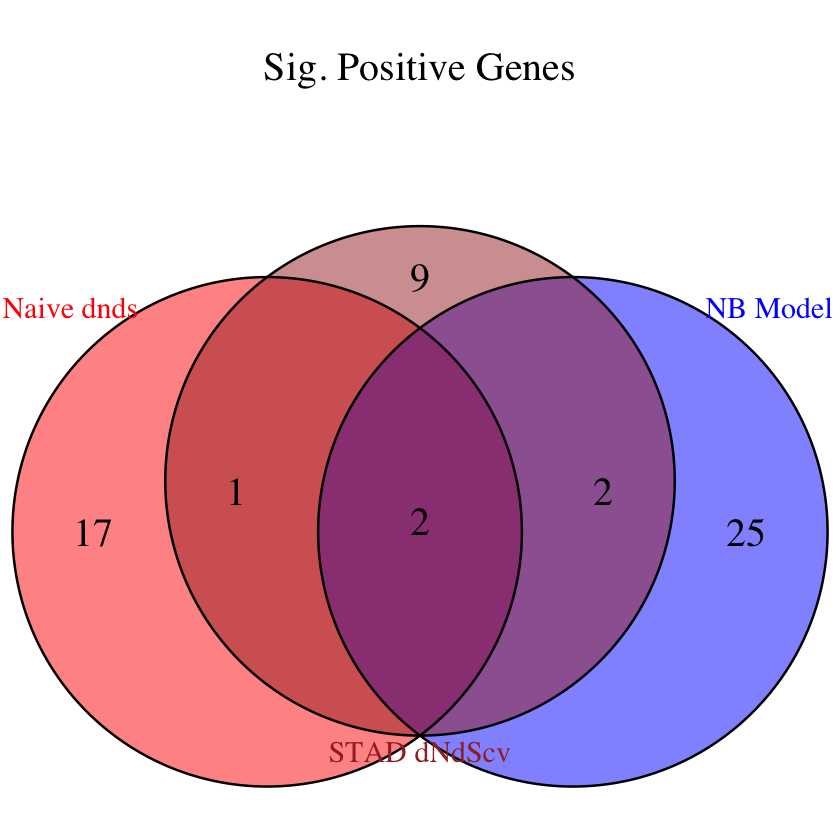

In [140]:
fill_colors <- c("red", "blue", "brown")

venn_plot <- venn.diagram(
  x = list(
      "Naive dnds" = naive_sig_genes,
      "NB Model" = nb_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      # "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Sig. Positive Genes",
  main.cex = 2,   
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1.5,
  cat.col = fill_colors,
  margin = 0
)
grid.draw(venn_plot)

# Combined clust2

In [149]:
mutation_counts_filtered_clust2 <- read_delim(
  "mutation_counts_filtered_clust2.tsv",
  delim = " ", 
  escape_double = TRUE,
  trim_ws = TRUE
)

Rows: 15876 Columns: 45
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr  (6): Hugo_Symbol, pos_selection, nb_selection, dndscv_selection, gm_sel...
dbl (39): observed_mutations, gene_length, log_gene_length, expected_mutatio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [151]:
# Poisson Model significant genes
pos_sig_genes <- union(
  mutation_counts_filtered %>%
    filter(pos_selection == "Positive", pos_adj_p_value < 0.05) %>%
    pull(Hugo_Symbol),
  mutation_counts_filtered_clust2 %>%
    filter(pos_selection == "Positive", pos_adj_p_value < 0.05) %>%
    pull(Hugo_Symbol)
) %>% unique()

# Negative Binomial Model significant genes
nb_sig_genes <- union(
  mutation_counts_filtered %>%
    filter(nb_selection == "Positive", nb_adj_p_value < 0.05) %>%
    pull(Hugo_Symbol),
  mutation_counts_filtered_clust2 %>%
    filter(nb_selection == "Positive", nb_adj_p_value < 0.05) %>%
    pull(Hugo_Symbol)
) %>% unique()

# dN/dS Model significant genes
dnds_sig_genes <- union(
  mutation_counts_filtered %>%
    filter(dnds_selection == "Positive", dnds_p_value < 0.05) %>%
    pull(Hugo_Symbol),
  mutation_counts_filtered_clust2 %>%
    filter(dnds_selection == "Positive", dnds_p_value < 0.05) %>%
    pull(Hugo_Symbol)
) %>% unique()

# Gamma Model significant genes
gm_sig_genes <- union(
  mutation_counts_filtered %>%
    filter(gm_selection == "Positive", gm_adj_p_value < 0.05) %>%
    pull(Hugo_Symbol),
  mutation_counts_filtered_clust2 %>%
    filter(gm_selection == "Positive", gm_adj_p_value < 0.05) %>%
    pull(Hugo_Symbol)
) %>% unique()

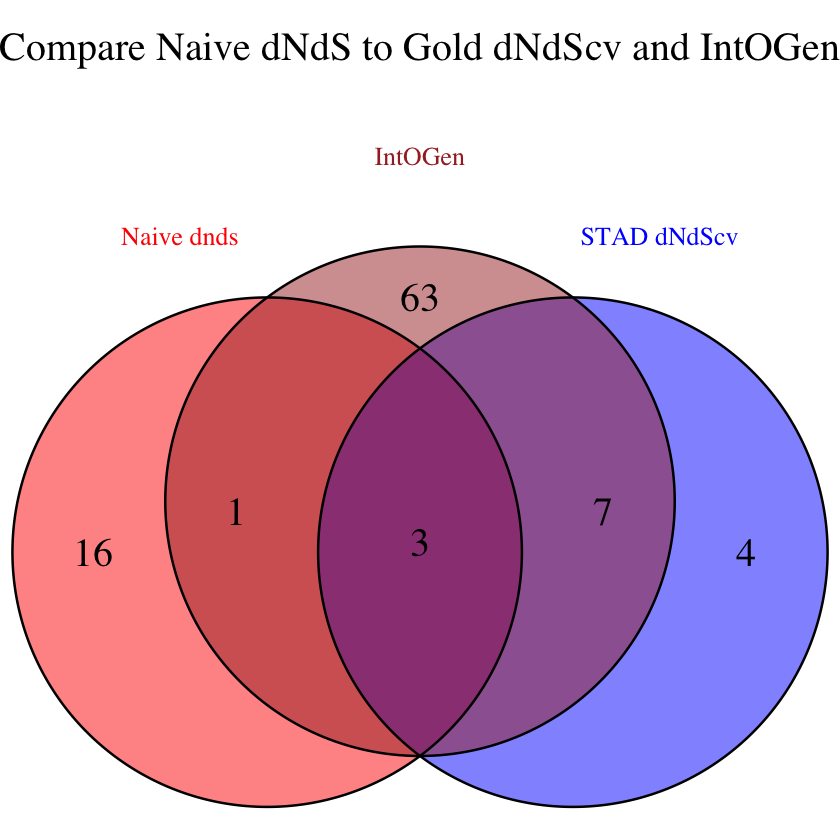

In [168]:
fill_colors <- c("red", "blue", "brown")

venn_plot <- venn.diagram(
  x = list(
      "Naive dnds" = naive_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes,
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Compare Naive dNdS to Gold dNdScv and IntOGen",
  main.cex = 2,   
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1.3,
  cat.col = fill_colors,
  cat.pos = c(-15, 15, 0),
  cat.dist = c(0.08, 0.08, 0.08),
  margin = 0
)
grid.draw(venn_plot)

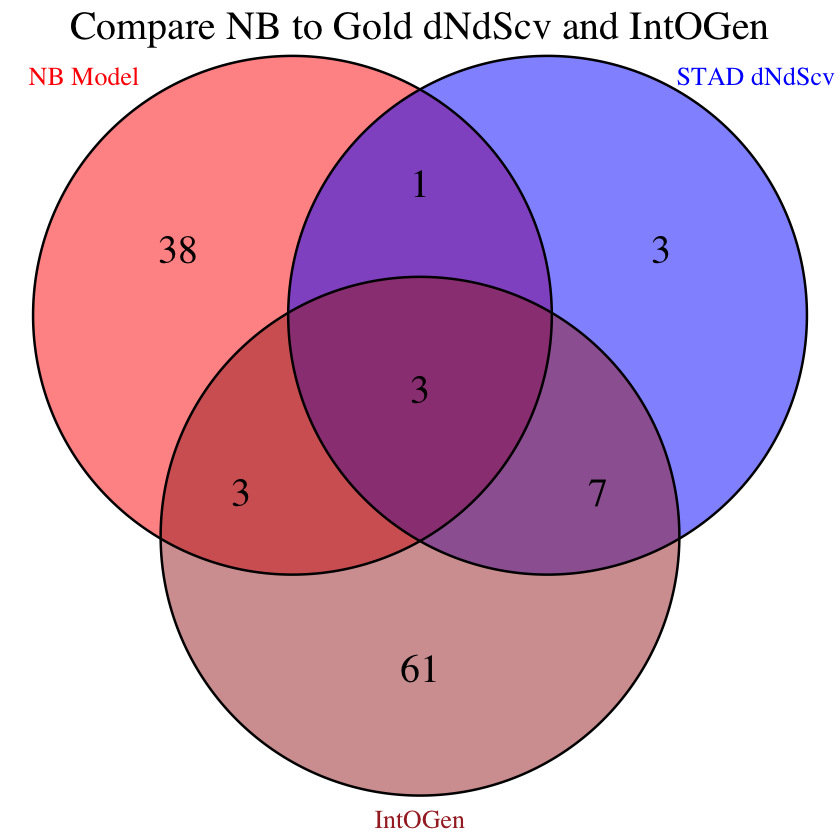

In [167]:
fill_colors <- c("red", "blue", "brown")

venn_plot <- venn.diagram(
  x = list(
      "NB Model" = nb_sig_genes,
      "STAD dNdScv" = dndscv_significant_genes,
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Compare NB to Gold dNdScv and IntOGen",
  main.cex = 2,   
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1.3,
  cat.col = fill_colors,
  # cat.pos = c(-15, 15, 0),
  # cat.dist = c(0.08, 0.08, 0.08),
  margin = 0
)
grid.draw(venn_plot)

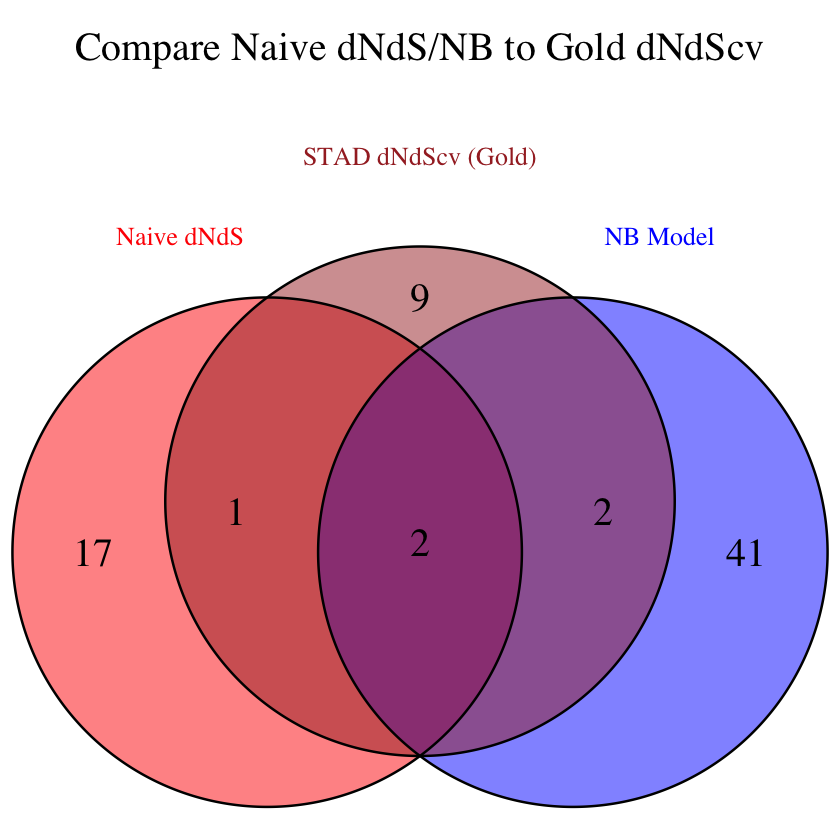

In [166]:
fill_colors <- c("red", "blue", "brown")

venn_plot <- venn.diagram(
  x = list(
      "Naive dNdS" = naive_sig_genes,
      "NB Model" = nb_sig_genes,
      "STAD dNdScv (Gold)" = dndscv_significant_genes
      # "FML" = FML_sig_genes,
      # "CLUSTL" = CLUSTL_sig,
      # "IntOGen" = IntOGen_genes
  ),
  filename = NULL,
  fill = fill_colors,
  main = "Compare Naive dNdS/NB to Gold dNdScv",
  main.cex = 2,   
  alpha = 0.5,
  label.col = "black",
  cex = 2,
  cat.cex = 1.3,
  cat.col = fill_colors,
  cat.pos = c(-15, 15, 0),
  cat.dist = c(0.08, 0.08, 0.08),
  margin = 0
)
grid.draw(venn_plot)

In [171]:
STAD_mutation = read_tsv("/Users/shuhaoxu/Desktop/BNFO285/Groupproject/Project2/TCGA.STAD.mutations.txt", quote="\"")

Rows: 234941 Columns: 53
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (44): patient_id, Hugo_Symbol, Center, NCBI_Build, Chromosome, Strand, V...
dbl  (9): Entrez_Gene_Id, Start_Position, End_Position, t_depth, t_ref_count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


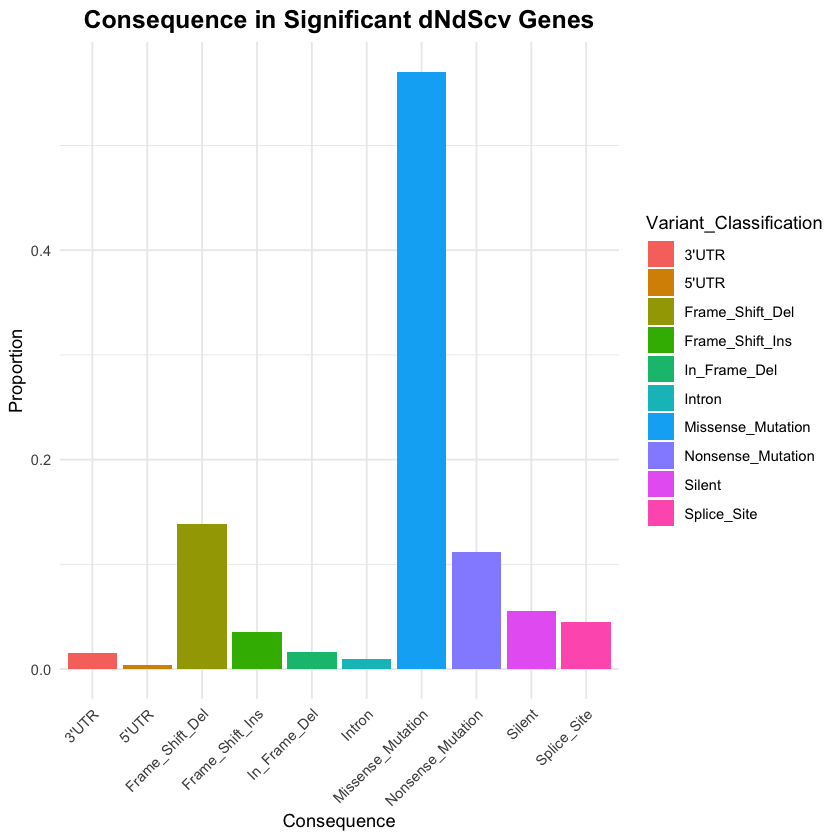

In [181]:
significant_genes <- dndscv_significant_genes
consequence_summary <- STAD_mutation %>%
  filter(Hugo_Symbol %in% significant_genes) %>%
  group_by(Hugo_Symbol, Variant_Classification) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(Variant_Classification) %>%
  summarise(total_count = sum(count), .groups = "drop")

consequence_summary <- consequence_summary %>%
  mutate(proportion = total_count / sum(total_count))

ggplot(consequence_summary, aes(x = Variant_Classification, y = proportion, fill = Variant_Classification)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Consequence in Significant dNdScv Genes",
    x = "Consequence", y = "Proportion"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 15, face = "bold", hjust = 0.5)
  )

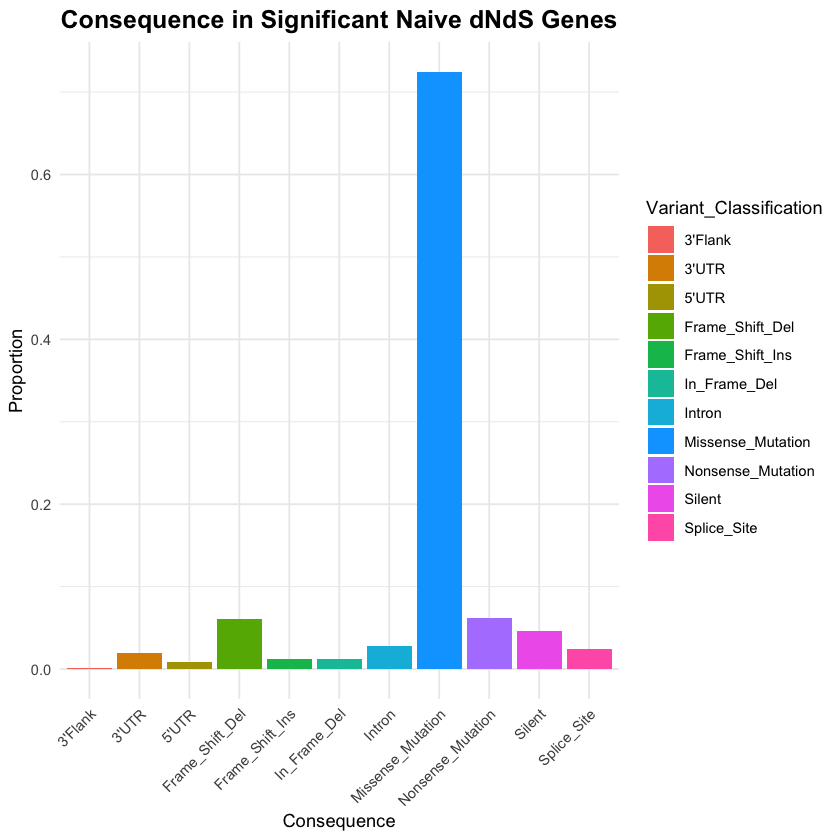

In [180]:
significant_genes <- naive_sig_genes
consequence_summary <- STAD_mutation %>%
  filter(Hugo_Symbol %in% significant_genes) %>%
  group_by(Hugo_Symbol, Variant_Classification) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(Variant_Classification) %>%
  summarise(total_count = sum(count), .groups = "drop")

consequence_summary <- consequence_summary %>%
  mutate(proportion = total_count / sum(total_count))

ggplot(consequence_summary, aes(x = Variant_Classification, y = proportion, fill = Variant_Classification)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Consequence in Significant Naive dNdS Genes",
    x = "Consequence", y = "Proportion"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 15, face = "bold", hjust = 0.5)
  )

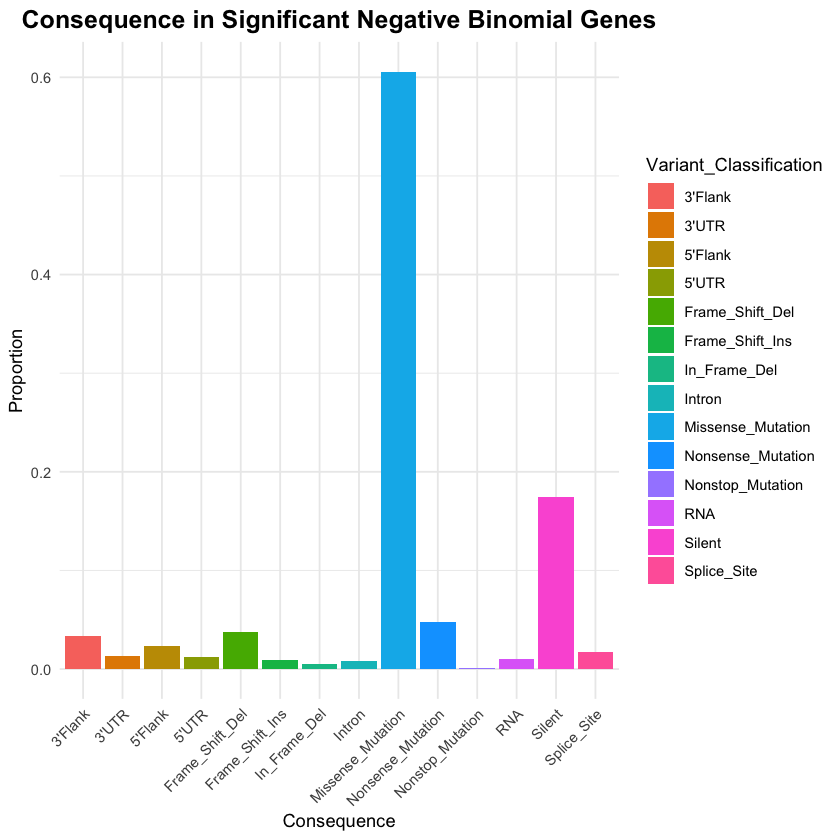

In [182]:
significant_genes <- nb_sig_genes
consequence_summary <- STAD_mutation %>%
  filter(Hugo_Symbol %in% significant_genes) %>%
  group_by(Hugo_Symbol, Variant_Classification) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(Variant_Classification) %>%
  summarise(total_count = sum(count), .groups = "drop")

consequence_summary <- consequence_summary %>%
  mutate(proportion = total_count / sum(total_count))

ggplot(consequence_summary, aes(x = Variant_Classification, y = proportion, fill = Variant_Classification)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Consequence in Significant Negative Binomial Genes",
    x = "Consequence", y = "Proportion"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 15, face = "bold", hjust = 0.5)
  )